In [1]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

In [2]:
import tensorflow_datasets as tfds

# Load the 'stanford_dogs' dataset
dataset_name = 'stanford_dogs'
(train_dataset, test_dataset), dataset_info = tfds.load(
    name=dataset_name,
    split=['train', 'test'],
    with_info=True,
    as_supervised=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteRNL1MI/stanford_dogs-train.tfrecord*...:   0…

Generating test examples...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteRNL1MI/stanford_dogs-test.tfrecord*...:   0%…

Dataset stanford_dogs downloaded and prepared to /root/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


In [16]:
 # Print the sizes of the training and test sets
print("Training Set:", dataset_info.splits['train'].num_examples)
print("Test Set:", dataset_info.splits['test'].num_examples)

# Print the number of classes
print("Number of Classes:", dataset_info.features['label'].num_classes)

Training Set: 12000
Test Set: 8580
Number of Classes: 120


In [4]:
# Preprocess the datasets
def preprocess_image(image, label):
    image = tf.image.resize(image, (224, 224))
    image = preprocess_input(image)
    return image, label

In [5]:
train_dataset = train_dataset.map(preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.map(preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)


In [6]:
# Build the MobileNetV2 model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the pre-trained layers

# Add custom classification head
global_average_layer = GlobalAveragePooling2D()
output_layer = Dense(120, activation='softmax')

model = tf.keras.Sequential([
    base_model,
    global_average_layer,
    output_layer
])

9406464/9406464 [==============================] - 0s 0us/step


In [7]:
# Compile the model
model.compile(optimizer=Adam(),
              loss=SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [8]:
# Train the model
batch_size = 32
train_dataset = train_dataset.batch(batch_size).shuffle(buffer_size=1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

epochs = 10

# Define some callbacks
checkpoint = ModelCheckpoint('my_model.keras', save_best_only=True, monitor='val_loss')
tensorboard = TensorBoard(log_dir='logs', histogram_freq=1)
early_stopping = EarlyStopping(patience=3, monitor='val_loss')

history = model.fit(train_dataset, epochs=epochs, validation_data=test_dataset, callbacks=[checkpoint, tensorboard, early_stopping])

Epoch 1/10
375/375 [==============================] - 70s 96ms/step - loss: 1.2361 - accuracy: 0.6941 - val_loss: 0.6451 - val_accuracy: 0.8082
Epoch 2/10
375/375 [==============================] - 57s 94ms/step - loss: 0.3992 - accuracy: 0.8845 - val_loss: 0.5552 - val_accuracy: 0.8283
Epoch 3/10
375/375 [==============================] - 60s 100ms/step - loss: 0.2513 - accuracy: 0.9312 - val_loss: 0.5296 - val_accuracy: 0.8346
Epoch 4/10
375/375 [==============================] - 56s 92ms/step - loss: 0.1725 - accuracy: 0.9596 - val_loss: 0.5308 - val_accuracy: 0.8358
Epoch 5/10
375/375 [==============================] - 55s 91ms/step - loss: 0.1248 - accuracy: 0.9768 - val_loss: 0.5296 - val_accuracy: 0.8372
Epoch 6/10
375/375 [==============================] - 51s 90ms/step - loss: 0.0920 - accuracy: 0.9855 - val_loss: 0.5214 - val_accuracy: 0.8355
Epoch 7/10
375/375 [==============================] - 49s 82ms/step - loss: 0.0706 - accuracy: 0.9910 - val_loss: 0.5349 - val_accuracy

In [9]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f'Test accuracy: {test_accuracy * 100:.2f}%')


269/269 [==============================] - 19s 71ms/step - loss: 0.5395 - accuracy: 0.8392
Test accuracy: 83.92%


1/1 [==============================] - 0s 97ms/step


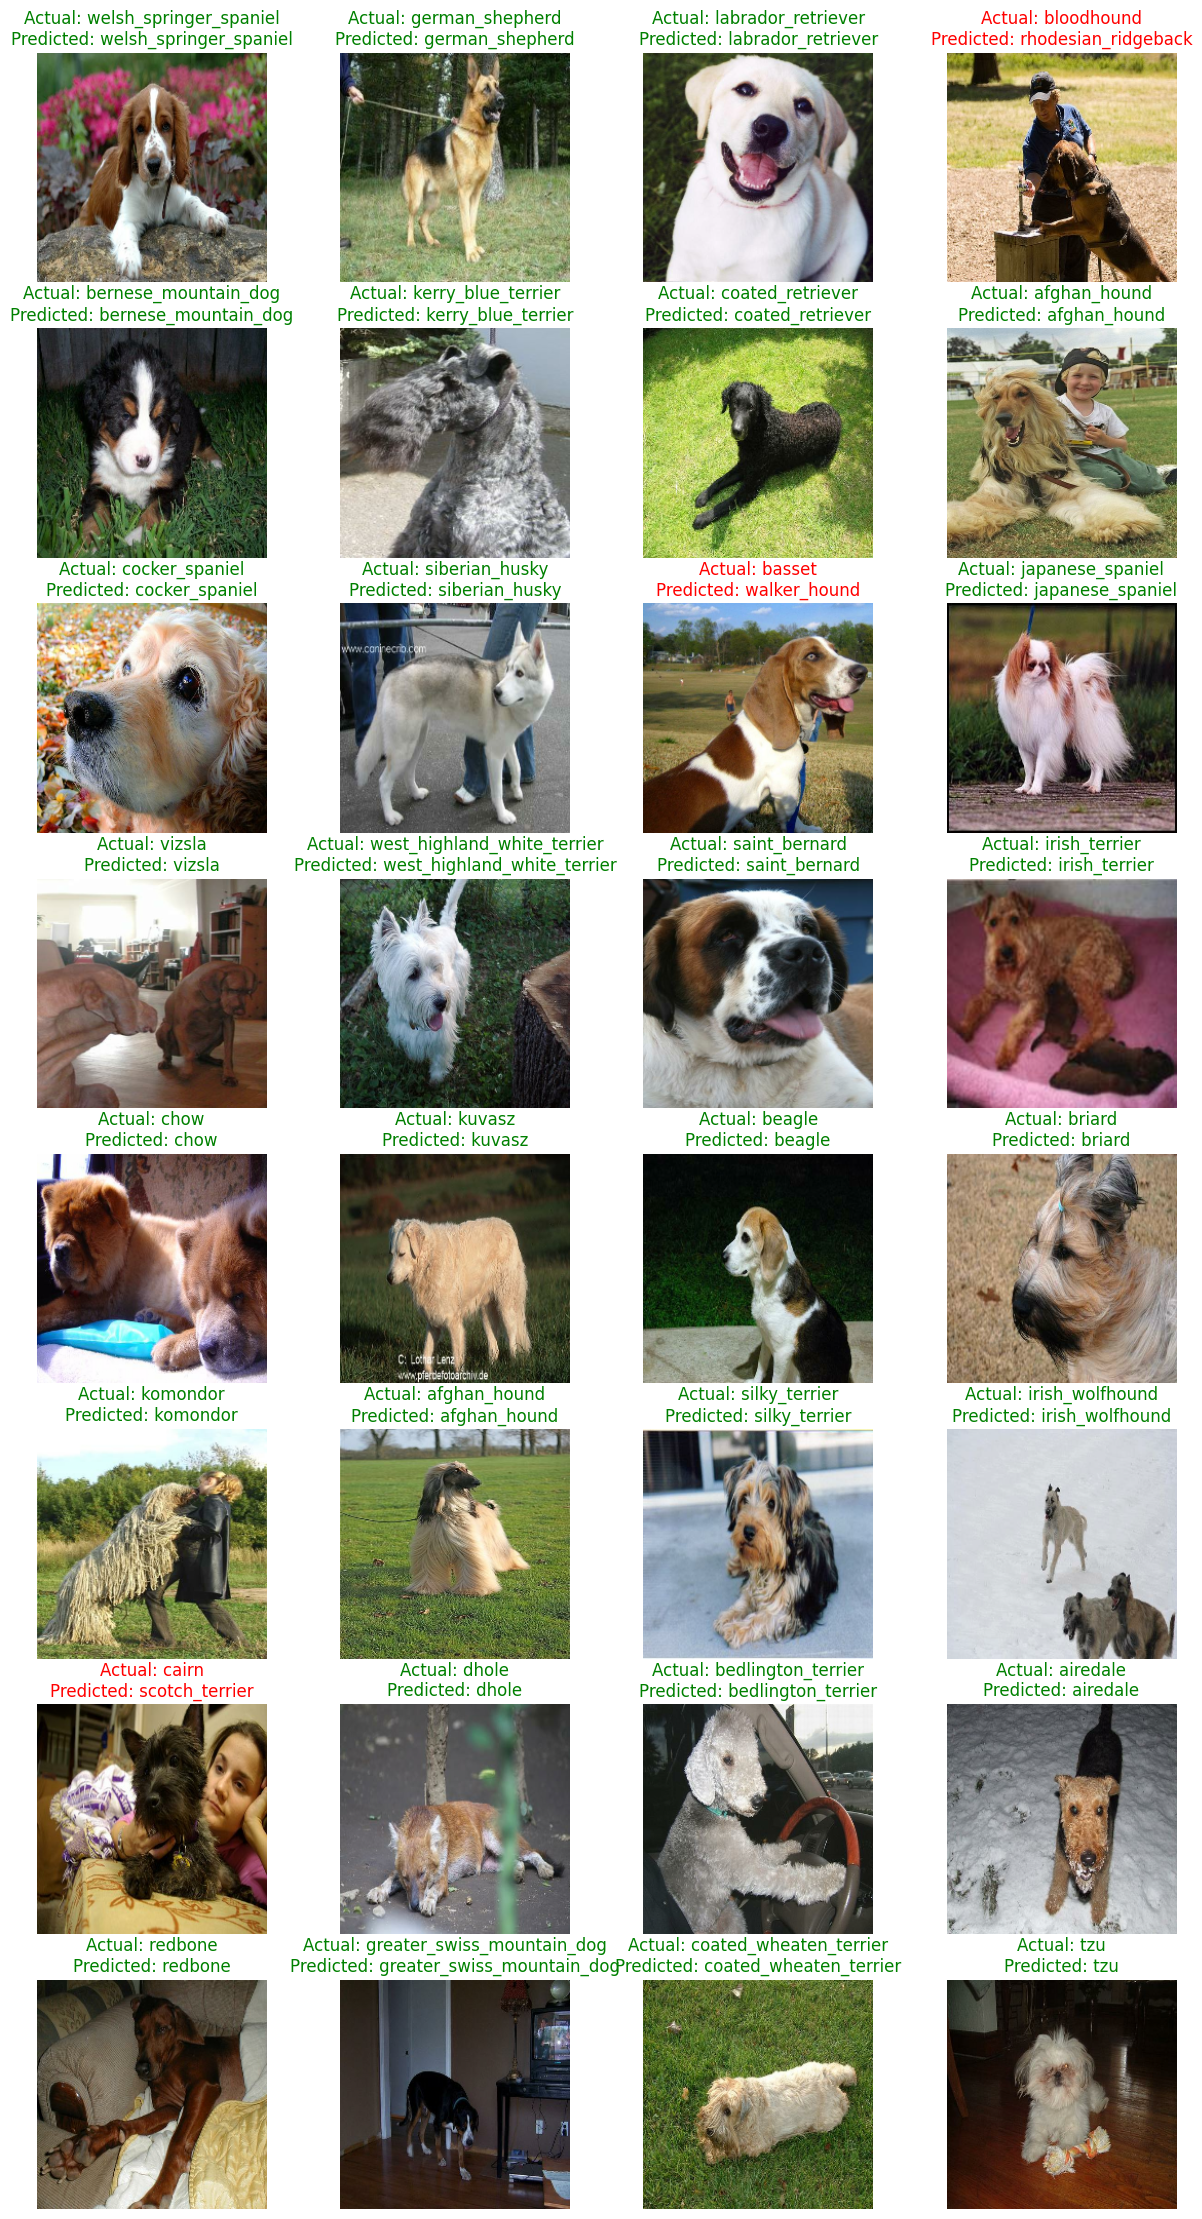

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Function to visualize predictions with class names
def visualize_predictions(model, test_dataset, class_names):
    # Get a batch of test data
    for images, labels in test_dataset.take(1):
        # Make predictions
        predictions = model.predict(images)
        predicted_classes = np.argmax(predictions, axis=1)

        # Determine the number of rows and columns in the subplot grid
        num_images = len(images)
        num_rows = int(np.ceil(num_images / 4))
        num_cols = min(4, num_images)

        # Display the images along with actual and predicted classes
        plt.figure(figsize=(15, 3.5 * num_rows))
        for i in range(num_images):
            plt.subplot(num_rows, num_cols, i+1)

            # Rescale pixel values to the range [0, 1]
            img = images[i].numpy()
            img = (img - np.min(img)) / (np.max(img) - np.min(img))

            plt.imshow(img)

            actual_class_name = class_names[int(labels[i].numpy())].split('-')[-1]
            predicted_class_name = class_names[predicted_classes[i]].split('-')[-1]
            plt.title(f'Actual: {actual_class_name}\nPredicted: {predicted_class_name}',
                      color='green' if actual_class_name == predicted_class_name else 'red')
            plt.axis('off')

        plt.show()

# Visualize predictions using the trained model and class names
visualize_predictions(model, test_dataset, class_names)
